In [1]:
# Loading libraries
%matplotlib inline
import os
import os.path
from netCDF4 import Dataset
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc 
import fnmatch
from cycler import cycler
import pandas as pd
from pandas import read_csv, to_datetime, DataFrame
import datetime
import time
import matplotlib.dates as mdates

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from mpl_toolkits.basemap import Basemap # Basemap pour les cartes

In [2]:
# LOADING GRID FILE AND VARIABLES
!pwd
grid_file = '../DATA/grille.nc' 
print 'file exist:', os.path.isfile(grid_file)

f = Dataset(grid_file) # open netcdf
# extracting variables
lon_t = f.variables['longitude_t'][:] # extracting lon data
lat_t = f.variables['latitude_t'][:] # extracting lat data
depth_t = f.variables['depth_t'][:]
bathy = f.variables['h_w'][:]
print 'Bathy :', np.shape(bathy), 'max :', np.max(bathy), 'min :', np.min(bathy)

f.close()

new_bath = np.ma.masked_where(bathy<200, bathy)
region_list = ['NWE', 'SWE', 'ION', 'LEV'] #

/home/dosa/MON_ENV_PYTHON/INTERANNUAL_VARIAB
file exist: True
Bathy : (160, 394) max : 5054.49 min : 20.5226


In [39]:
# 29/06 loading matlab variables to draw a map  with sat images (ESA-CCI)
# February #
import scipy.io as sio

sat_rep = '../DATA/LONG_SIMS/BestAjustRivE_BoostW/MONTHMEAN_SAT/'
temp_array = sio.loadmat(sat_rep+'data_CCI_SCS_mois_2007.mat')

#test
new_lon_cci = np.zeros([1033,385])
new_lon_cci[:] = np.nan

for i in np.arange(0,385):
    new_lon_cci[:,i] = temp_array['lon_cci'][:,0]

new_lat_cci = np.zeros([1033,385])
new_lat_cci[:] = np.nan

for i in np.arange(0,1033):
    new_lat_cci[i,:] = temp_array['lat_cci'][:,0]
    
new_chla_cci = temp_array['chla_cci'][:,:,1] # here dim [:,:,1] = 2nd month = february
# dim [:,:,2] = 3rd month = march

print 'new_lon_cci:', np.shape(new_lon_cci), 'new_lat_cci:', np.shape(new_lat_cci)  
print 'new_chla_cci:', np.shape(new_chla_cci)

new_lon_cci: (1033, 385) new_lat_cci: (1033, 385)
new_chla_cci: (1033, 385)


Chl Tot : (160, 394) max : 3.11005 min : 0.029385


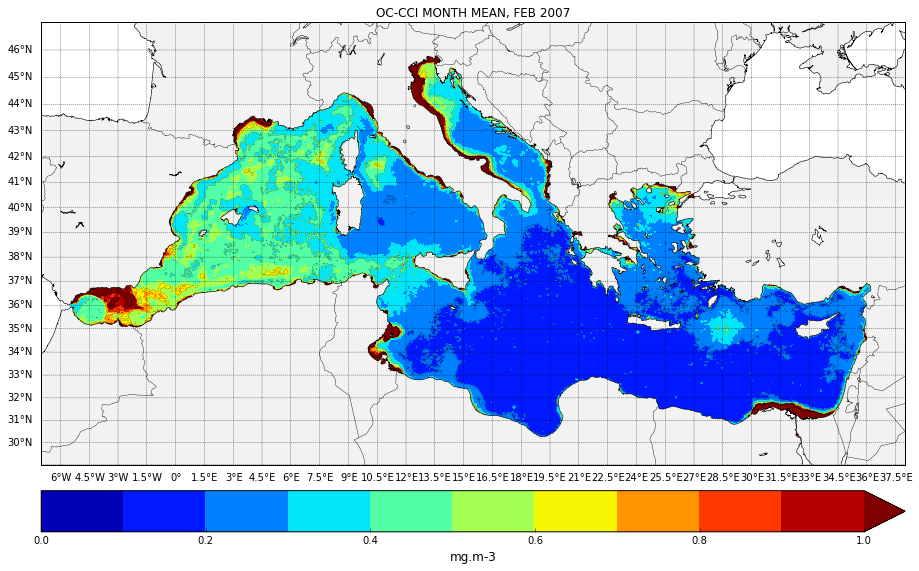

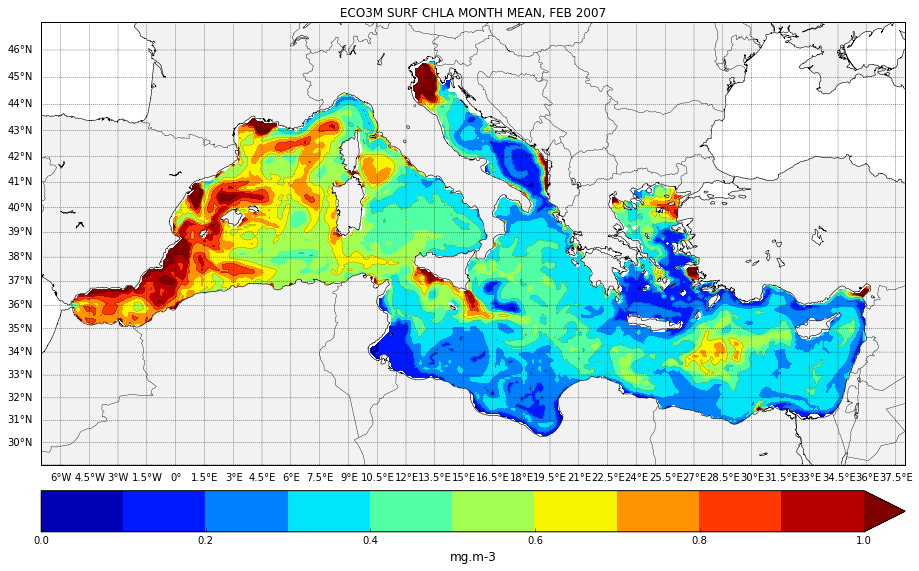

In [43]:
# COMPARING SAT MONTHLY IMAGES vs MODEL OUTPUTS MONTHLY MEANS SURF CHLA
## FEBRUARY ##

# ALL_MED
y = [37,44,46,42,39,38,30,30,35,35];
x = [-5.5,3,13.5,25.5,28.5,36.5,36.5,10,10,-5.5];

x1,x2,y1,y2 = -7, 38, 29, 47;
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,lat_ts=(x1+x2)/2);
            # figure
fig = plt.figure(figsize=(15,15));
ax = fig.add_axes([0.1,0.1,0.8,0.8]);
m.drawcountries(linewidth=0.4);
m.drawcoastlines(linewidth=0.6);
m.fillcontinents(color='0.95',lake_color='white');
parallels = np.arange(0.,81,1);
m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0.4);
meridians = np.arange(-6.,351.,1.5);
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.4);

# Selecting the data
vertices = np.array([np.hstack((x, 0)),np.hstack((y, 0))],float).transpose();
path = Path(vertices, codes=None, closed=True);
indices = path.contains_points(np.array([np.reshape(new_lon_cci,(np.size(new_lon_cci))),np.reshape(new_lat_cci,(np.size(new_lat_cci)))]).T,\
                transform=None, radius=0.0)
indices_re = np.reshape(indices,np.shape(new_lon_cci))# this our mask for the zone

data_to_plot = np.ma.masked_array(new_chla_cci,indices_re==False)

# Polygone
#xx,yy = m(x,y); # conversion coordonnées
#vertices = np.array([np.hstack((xx, 0)),np.hstack((yy, 0))],float).transpose();
#path = Path(vertices, codes=None, closed=True);
#pathpatch = PathPatch(path, facecolor='None', edgecolor='red',linewidth=1.);
#ax.add_patch(pathpatch); # affichage du polygone
#ax.scatter(xx,yy, s=100, c='b', marker='o',zorder=6); # ajoute les points

# Données
xd,yd = m(new_lon_cci,new_lat_cci);
levels = np.arange(0,1.1,0.1);
levels2 = np.arange(0,1.6,0.2);
CS1 = m.contour(xd,yd,data_to_plot,levels=levels2,linewidths=0.2,colors='k');
cs = m.contourf(xd,yd,data_to_plot,levels=levels,cmap=plt.cm.jet,extend='max');# binary / jet levels=levels,

plt.title("OC-CCI MONTH MEAN, FEB 2007")

cb = plt.colorbar(cs, orientation='horizontal', pad = 0.03)
cb.set_label("mg.m-3", fontsize=12)

# Loading monthly means of surf chla in 2007 to compare with sat images
### FEBRUARY ###

f = Dataset(sat_rep+'moyenne07_month_02_chlsurf.nc') # open netcdf
# extracting variables
chl_surf = f.variables['chl_tot'][0,0,:,:] # extracting data
print 'Chl Tot :', np.shape(chl_surf), 'max :', np.max(chl_surf), 'min :', np.min(chl_surf)
f.close()

x1,x2,y1,y2 = -7, 38, 29, 47;
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,lat_ts=(x1+x2)/2);
            # figure
fig = plt.figure(figsize=(15,15));
ax = fig.add_axes([0.1,0.1,0.8,0.8]);
m.drawcountries(linewidth=0.4);
m.drawcoastlines(linewidth=0.6);
m.fillcontinents(color='0.95',lake_color='white');
parallels = np.arange(0.,81,1);
m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0.4);
meridians = np.arange(-6.,351.,1.5);
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.4);

# Selecting the data
vertices = np.array([np.hstack((x, 0)),np.hstack((y, 0))],float).transpose();
path = Path(vertices, codes=None, closed=True);
indices = path.contains_points(np.array([np.reshape(lon_t,(np.size(lon_t))),np.reshape(lat_t,(np.size(lat_t)))]).T,\
                transform=None, radius=0.0)
indices_re = np.reshape(indices,np.shape(lon_t))# this our mask for the zone

# Creating corresponding variable names
data_to_plot = np.ma.masked_array(chl_surf,indices_re==False)

# Données
xd,yd = m(lon_t,lat_t);
levels = np.arange(0,1.1,0.1);
levels2 = np.arange(0,1.6,0.2);
CS1 = m.contour(xd,yd,data_to_plot,levels=levels2,linewidths=0.2,colors='k');
cs = m.contourf(xd,yd,data_to_plot,levels=levels,cmap=plt.cm.jet,extend='max');# binary / jet, levels=levels,

plt.title("ECO3M SURF CHLA MONTH MEAN, FEB 2007")

cb = plt.colorbar(cs, orientation='horizontal', pad = 0.03)
cb.set_label("mg.m-3", fontsize=12)

In [44]:
# 29/06 loading matlab variables to draw a map  with sat images (ESA-CCI)
# March #
import scipy.io as sio

sat_rep = '../DATA/LONG_SIMS/BestAjustRivE_BoostW/MONTHMEAN_SAT/'
temp_array = sio.loadmat(sat_rep+'data_CCI_SCS_mois_2007.mat')

#test
new_lon_cci = np.zeros([1033,385])
new_lon_cci[:] = np.nan

for i in np.arange(0,385):
    new_lon_cci[:,i] = temp_array['lon_cci'][:,0]

new_lat_cci = np.zeros([1033,385])
new_lat_cci[:] = np.nan

for i in np.arange(0,1033):
    new_lat_cci[i,:] = temp_array['lat_cci'][:,0]
    
new_chla_cci = temp_array['chla_cci'][:,:,2] # here dim [:,:,1] = 2nd month = february
# dim [:,:,2] = 3rd month = march

print 'new_lon_cci:', np.shape(new_lon_cci), 'new_lat_cci:', np.shape(new_lat_cci)  
print 'new_chla_cci:', np.shape(new_chla_cci)

new_lon_cci: (1033, 385) new_lat_cci: (1033, 385)
new_chla_cci: (1033, 385)


Chl Tot : (160, 394) max : 4.2521 min : 0.0196052


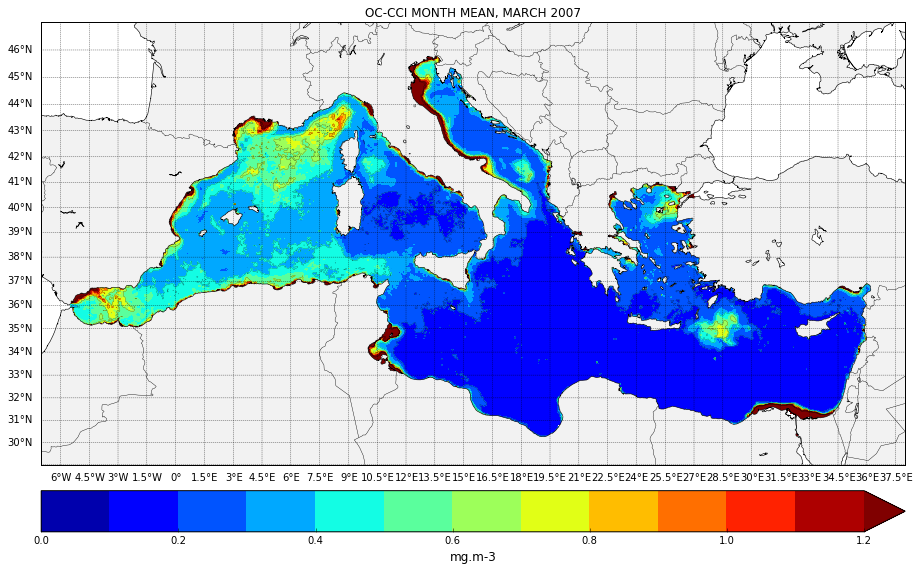

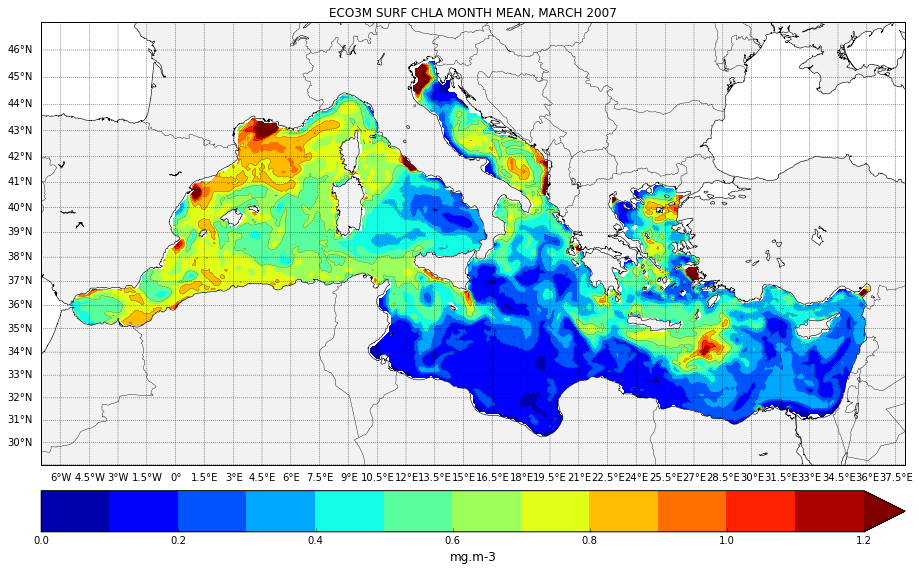

In [49]:
# COMPARING SAT MONTHLY IMAGES vs MODEL OUTPUTS MONTHLY MEANS SURF CHLA
## MARCH ##

# ALL_MED
y = [37,44,46,42,39,38,30,30,35,35];
x = [-5.5,3,13.5,25.5,28.5,36.5,36.5,10,10,-5.5];

x1,x2,y1,y2 = -7, 38, 29, 47;
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,lat_ts=(x1+x2)/2);
            # figure
fig = plt.figure(figsize=(15,15));
ax = fig.add_axes([0.1,0.1,0.8,0.8]);
m.drawcountries(linewidth=0.4);
m.drawcoastlines(linewidth=0.6);
m.fillcontinents(color='0.95',lake_color='white');
parallels = np.arange(0.,81,1);
m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0.4);
meridians = np.arange(-6.,351.,1.5);
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.4);

# Selecting the data
vertices = np.array([np.hstack((x, 0)),np.hstack((y, 0))],float).transpose();
path = Path(vertices, codes=None, closed=True);
indices = path.contains_points(np.array([np.reshape(new_lon_cci,(np.size(new_lon_cci))),np.reshape(new_lat_cci,(np.size(new_lat_cci)))]).T,\
                transform=None, radius=0.0)
indices_re = np.reshape(indices,np.shape(new_lon_cci))# this our mask for the zone

data_to_plot = np.ma.masked_array(new_chla_cci,indices_re==False)

# Polygone
#xx,yy = m(x,y); # conversion coordonnées
#vertices = np.array([np.hstack((xx, 0)),np.hstack((yy, 0))],float).transpose();
#path = Path(vertices, codes=None, closed=True);
#pathpatch = PathPatch(path, facecolor='None', edgecolor='red',linewidth=1.);
#ax.add_patch(pathpatch); # affichage du polygone
#ax.scatter(xx,yy, s=100, c='b', marker='o',zorder=6); # ajoute les points

# Données
xd,yd = m(new_lon_cci,new_lat_cci);
levels = np.arange(0,1.3,0.1);
levels2 = np.arange(0,1.6,0.2);
CS1 = m.contour(xd,yd,data_to_plot,levels=levels2,linewidths=0.2,colors='k');
cs = m.contourf(xd,yd,data_to_plot,levels=levels,cmap=plt.cm.jet,extend='max');# binary / jet levels=levels,

plt.title("OC-CCI MONTH MEAN, MARCH 2007")

cb = plt.colorbar(cs, orientation='horizontal', pad = 0.03)
cb.set_label("mg.m-3", fontsize=12)

# Loading monthly means of surf chla in 2007 to compare with sat images
### MARCH ###

f = Dataset(sat_rep+'moyenne07_month_03_chlsurf.nc') # open netcdf
# extracting variables
chl_surf = f.variables['chl_tot'][0,0,:,:] # extracting data
print 'Chl Tot :', np.shape(chl_surf), 'max :', np.max(chl_surf), 'min :', np.min(chl_surf)
f.close()

x1,x2,y1,y2 = -7, 38, 29, 47;
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,lat_ts=(x1+x2)/2);
            # figure
fig = plt.figure(figsize=(15,15));
ax = fig.add_axes([0.1,0.1,0.8,0.8]);
m.drawcountries(linewidth=0.4);
m.drawcoastlines(linewidth=0.6);
m.fillcontinents(color='0.95',lake_color='white');
parallels = np.arange(0.,81,1);
m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0.4);
meridians = np.arange(-6.,351.,1.5);
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.4);

# Selecting the data
vertices = np.array([np.hstack((x, 0)),np.hstack((y, 0))],float).transpose();
path = Path(vertices, codes=None, closed=True);
indices = path.contains_points(np.array([np.reshape(lon_t,(np.size(lon_t))),np.reshape(lat_t,(np.size(lat_t)))]).T,\
                transform=None, radius=0.0)
indices_re = np.reshape(indices,np.shape(lon_t))# this our mask for the zone

# Creating corresponding variable names
data_to_plot = np.ma.masked_array(chl_surf,indices_re==False)

# Données
xd,yd = m(lon_t,lat_t);
levels = np.arange(0,1.3,0.1);
levels2 = np.arange(0,1.6,0.2);
CS1 = m.contour(xd,yd,data_to_plot,levels=levels2,linewidths=0.2,colors='k');
cs = m.contourf(xd,yd,data_to_plot,levels=levels,cmap=plt.cm.jet,extend='max');# binary / jet, levels=levels,

plt.title("ECO3M SURF CHLA MONTH MEAN, MARCH 2007")

cb = plt.colorbar(cs, orientation='horizontal', pad = 0.03)
cb.set_label("mg.m-3", fontsize=12)